In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from string import ascii_lowercase

from IPython.display import display
import numpy as np
import pandas as pd

from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from ml_lab.model_selection import GroupTimeSeriesSplit

In [3]:
RANDOM_STATE = 42

## Prepare sample data

### Monthly data

In [4]:
rng = np.random.default_rng(RANDOM_STATE)

start_date = '2021-01-01'
end_date = '2021-12-01'

unique_months = pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m')
times = rng.integers(low=1, high=5, size=len(unique_months))
months = unique_months.repeat(times)
months

Index(['2021-01', '2021-02', '2021-02', '2021-02', '2021-02', '2021-03',
       '2021-03', '2021-03', '2021-04', '2021-04', '2021-05', '2021-05',
       '2021-06', '2021-06', '2021-06', '2021-06', '2021-07', '2021-08',
       '2021-08', '2021-08', '2021-09', '2021-10', '2021-11', '2021-11',
       '2021-11', '2021-12', '2021-12', '2021-12', '2021-12'],
      dtype='object')

**Generate monthly groups**

In [5]:
groups, _ = pd.factorize(months)
groups

array([ 0,  1,  1,  1,  1,  2,  2,  2,  3,  3,  4,  4,  5,  5,  5,  5,  6,
        7,  7,  7,  8,  9, 10, 10, 10, 11, 11, 11, 11])

### Features and targets

In [6]:
rng = np.random.default_rng(RANDOM_STATE)

data_size = len(groups)

num_feature = rng.random(data_size)
X = pd.DataFrame({
    'num_feature': num_feature
}, index=months)

targets = rng.choice([0, 1], size=data_size)
y = pd.Series(targets, name='target')

display(X.head(), y.head())

,num_feature
2021-01,0.773956
2021-02,0.438878
2021-02,0.858598
2021-02,0.697368
2021-02,0.094177


0    1
1    1
2    1
3    1
4    0
Name: target, dtype: int64

## Define test function

In [7]:
def test_cv(X, y, groups, **cv_args):
    cv = GroupTimeSeriesSplit(**cv_args)
    
    for train_idx, test_idx in cv.split(X, groups=groups):
        print('TRAIN INDICES:', train_idx)
        print('TEST INDICES:', test_idx)
        print('TRAIN LENGTH:', len(train_idx))
        print('TEST LENGTH:', len(test_idx))
        print('TRAIN GROUPS:', groups[train_idx]) 
        print('TEST GROUPS:', groups[test_idx])
        print('TRAIN GROUP SIZE:', len(set(groups[train_idx]))) 
        print('TEST GROUP SIZE:', len(set(groups[test_idx])))
        print('TRAIN GROUP MONTHS:', X.index[train_idx].values) 
        print('TEST GROUP MONTHS:', X.index[test_idx].values)
        print()

## Check train/test split

In [8]:
cv_args = {
    'test_size': 3, 
    'n_splits': 1,
    'gap': 0
}

In [9]:
test_cv(X, y, groups, **cv_args)

TRAIN INDICES: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
TEST INDICES: [21 22 23 24 25 26 27 28]
TRAIN LENGTH: 21
TEST LENGTH: 8
TRAIN GROUPS: [0 1 1 1 1 2 2 2 3 3 4 4 5 5 5 5 6 7 7 7 8]
TEST GROUPS: [ 9 10 10 10 11 11 11 11]
TRAIN GROUP SIZE: 9
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03'
 '2021-03' '2021-04' '2021-04' '2021-05' '2021-05' '2021-06' '2021-06'
 '2021-06' '2021-06' '2021-07' '2021-08' '2021-08' '2021-08' '2021-09']
TEST GROUP MONTHS: ['2021-10' '2021-11' '2021-11' '2021-11' '2021-12' '2021-12' '2021-12'
 '2021-12']



In [10]:
cv = GroupTimeSeriesSplit(**cv_args)
train_idx, test_idx = next(cv.split(X, groups=groups))

## Check cross-validation split

In [11]:
X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]
groups_train = groups[train_idx]

### Failed cases

- Groups are not sorted
- Both train_size and n_splits are specified
- Incorrect window name
- Specify train_size with expanding window
- Not enough data (too many number of splits)
- Not enough data (too large value of shift size)
- Not enough data (too large value of gap)
- Repeated usage of the same cv object
- (TODO) Incorrect range of parameters

**Groups are not sorted**

In [12]:
rng = np.random.default_rng(RANDOM_STATE)

unsorted_groups_train = groups_train.copy()
rng.shuffle(unsorted_groups_train)

unsorted_groups_train

array([6, 4, 5, 8, 5, 5, 2, 2, 3, 1, 0, 7, 2, 4, 7, 1, 1, 7, 1, 5, 3])

In [13]:
try:
    test_cv(X_train, y_train, unsorted_groups_train, **cv_args)
except ValueError as e:
    print(e)

Groups must be presorted in increasing order


**Both train_size and n_splits are not specified**

In [14]:
cv_args = {
    'test_size': 3
}

try:
    test_cv(X_train, y_train, groups_train, **cv_args)
except ValueError as e:
    print(e)

Either train_size or n_splits have to be defined


**Incorrect window name**

In [15]:
cv_args = {
    'test_size': 3,
    'n_splits': 3,
    'window': 'bad_name'
}

try:
    test_cv(X_train, y_train, groups_train, **cv_args)
except ValueError as e:
    print(e)

Window can be either "rolling" or "expanding"


**Specify train_size with expanding window**

In [16]:
cv_args = {
    'test_size': 3,
    'train_size': 3,
    'window': 'expanding'
}

try:
    test_cv(X_train, y_train, groups_train, **cv_args)
except ValueError as e:
    print(e)

Train size can be specified only with rolling window


**Not enough data (too large train_size and/or n_splits)**

In [17]:
cv_args = {
    'test_size': 3,
    'train_size': 7, 
    'n_splits': 1
}

try:
    test_cv(X_train, y_train, groups_train, **cv_args)
except ValueError as e:
    print(e)

Not enough data to split number of groups (9) for number splits (1) with train size (7), test size (3), gap (0), shift_size (1)


**Not enough data (too many number of splits)**

In [18]:
cv_args = {
    'test_size': 3,
    'n_splits': 10
}

try:
    test_cv(X_train, y_train, groups_train, **cv_args)
except ValueError as e:
    print(e)

Not enough data to split number of groups (9) for number splits (10) with train size (-3), test size (3), gap (0), shift_size (1)


**Not enough data (too large values of shift size)**

In [19]:
cv_args = {
    'test_size': 3,
    'n_splits': 3,
    'shift_size': 10
}

try:
    test_cv(X_train, y_train, groups_train, **cv_args)
except ValueError as e:
    print(e)

Not enough data to split number of groups (9) for number splits (3) with train size (-14), test size (3), gap (0), shift_size (10)


**Not enough data (too large values of gap)**

In [20]:
cv_args = {
    'test_size': 3,
    'n_splits': 3,
    'gap': 10
}

try:
    test_cv(X_train, y_train, groups_train, **cv_args)
except ValueError as e:
    print(e)

Not enough data to split number of groups (9) for number splits (3) with train size (-6), test size (3), gap (10), shift_size (1)


### Success cases

- test_size + train_size 
- test_size + n_splits
- test_size + n_splits + gap
- test_size + n_splits + shift_size
- test_size + n_splits + expanding window
- test_size + train_size + n_splits
- Repeated usage of the same object

**test_size + train_size**

In [21]:
cv_args = {
    'test_size': 3,
    'train_size': 3
}

test_cv(X_train, y_train, groups_train, **cv_args)

TRAIN INDICES: [0 1 2 3 4 5 6 7]
TEST INDICES: [ 8  9 10 11 12 13 14 15]
TRAIN LENGTH: 8
TEST LENGTH: 8
TRAIN GROUPS: [0 1 1 1 1 2 2 2]
TEST GROUPS: [3 3 4 4 5 5 5 5]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03'
 '2021-03']
TEST GROUP MONTHS: ['2021-04' '2021-04' '2021-05' '2021-05' '2021-06' '2021-06' '2021-06'
 '2021-06']

TRAIN INDICES: [1 2 3 4 5 6 7 8 9]
TEST INDICES: [10 11 12 13 14 15 16]
TRAIN LENGTH: 9
TEST LENGTH: 7
TRAIN GROUPS: [1 1 1 1 2 2 2 3 3]
TEST GROUPS: [4 4 5 5 5 5 6]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03' '2021-03'
 '2021-04' '2021-04']
TEST GROUP MONTHS: ['2021-05' '2021-05' '2021-06' '2021-06' '2021-06' '2021-06' '2021-07']

TRAIN INDICES: [ 5  6  7  8  9 10 11]
TEST INDICES: [12 13 14 15 16 17 18 19]
TRAIN LENGTH: 7
TEST LENGTH: 8
TRAIN GROUPS: [2 2 2 3 3 4 4]
TEST GROUPS: [5 5 5 5 6 7 7 7]
TRAIN GR

**test_size + n_splits**

In [22]:
cv_args = {
    'test_size': 3,
    'n_splits': 3
}

test_cv(X_train, y_train, groups_train, **cv_args)

TRAIN INDICES: [0 1 2 3 4 5 6 7 8 9]
TEST INDICES: [10 11 12 13 14 15 16]
TRAIN LENGTH: 10
TEST LENGTH: 7
TRAIN GROUPS: [0 1 1 1 1 2 2 2 3 3]
TEST GROUPS: [4 4 5 5 5 5 6]
TRAIN GROUP SIZE: 4
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03'
 '2021-03' '2021-04' '2021-04']
TEST GROUP MONTHS: ['2021-05' '2021-05' '2021-06' '2021-06' '2021-06' '2021-06' '2021-07']

TRAIN INDICES: [ 1  2  3  4  5  6  7  8  9 10 11]
TEST INDICES: [12 13 14 15 16 17 18 19]
TRAIN LENGTH: 11
TEST LENGTH: 8
TRAIN GROUPS: [1 1 1 1 2 2 2 3 3 4 4]
TEST GROUPS: [5 5 5 5 6 7 7 7]
TRAIN GROUP SIZE: 4
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03' '2021-03'
 '2021-04' '2021-04' '2021-05' '2021-05']
TEST GROUP MONTHS: ['2021-06' '2021-06' '2021-06' '2021-06' '2021-07' '2021-08' '2021-08'
 '2021-08']

TRAIN INDICES: [ 5  6  7  8  9 10 11 12 13 14 15]
TEST INDICES: [16 17 18 19 20]
TRAIN LENGTH: 11
TEST LENGTH

**test_size + n_splits + gap**

In [23]:
cv_args = {
    'test_size': 3,
    'n_splits': 3,
    'gap': 2
}

test_cv(X_train, y_train, groups_train, **cv_args)

TRAIN INDICES: [0 1 2 3 4]
TEST INDICES: [10 11 12 13 14 15 16]
TRAIN LENGTH: 5
TEST LENGTH: 7
TRAIN GROUPS: [0 1 1 1 1]
TEST GROUPS: [4 4 5 5 5 5 6]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02']
TEST GROUP MONTHS: ['2021-05' '2021-05' '2021-06' '2021-06' '2021-06' '2021-06' '2021-07']

TRAIN INDICES: [1 2 3 4 5 6 7]
TEST INDICES: [12 13 14 15 16 17 18 19]
TRAIN LENGTH: 7
TEST LENGTH: 8
TRAIN GROUPS: [1 1 1 1 2 2 2]
TEST GROUPS: [5 5 5 5 6 7 7 7]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03' '2021-03']
TEST GROUP MONTHS: ['2021-06' '2021-06' '2021-06' '2021-06' '2021-07' '2021-08' '2021-08'
 '2021-08']

TRAIN INDICES: [5 6 7 8 9]
TEST INDICES: [16 17 18 19 20]
TRAIN LENGTH: 5
TEST LENGTH: 5
TRAIN GROUPS: [2 2 2 3 3]
TEST GROUPS: [6 7 7 7 8]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04']

**test_size + n_splits + shift_size**

In [24]:
cv_args = {
    'test_size': 3,
    'n_splits': 3,
    'shift_size': 2
}

test_cv(X_train, y_train, groups_train, **cv_args)

TRAIN INDICES: [0 1 2 3 4]
TEST INDICES: [ 5  6  7  8  9 10 11]
TRAIN LENGTH: 5
TEST LENGTH: 7
TRAIN GROUPS: [0 1 1 1 1]
TEST GROUPS: [2 2 2 3 3 4 4]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02']
TEST GROUP MONTHS: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04' '2021-05' '2021-05']

TRAIN INDICES: [5 6 7 8 9]
TEST INDICES: [10 11 12 13 14 15 16]
TRAIN LENGTH: 5
TEST LENGTH: 7
TRAIN GROUPS: [2 2 2 3 3]
TEST GROUPS: [4 4 5 5 5 5 6]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04']
TEST GROUP MONTHS: ['2021-05' '2021-05' '2021-06' '2021-06' '2021-06' '2021-06' '2021-07']

TRAIN INDICES: [10 11 12 13 14 15]
TEST INDICES: [16 17 18 19 20]
TRAIN LENGTH: 6
TEST LENGTH: 5
TRAIN GROUPS: [4 4 5 5 5 5]
TEST GROUPS: [6 7 7 7 8]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-05' '2021-05' '2021-06' '2021-06' '2021-06' '2021-06']
TEST GROUP MONTHS: ['20

**test_size + n_splits + expanding window**

In [25]:
cv_args = {
    'test_size': 3,
    'n_splits': 3,
    'window': 'expanding'
}

test_cv(X_train, y_train, groups_train, **cv_args)

TRAIN INDICES: [0 1 2 3 4 5 6 7 8 9]
TEST INDICES: [10 11 12 13 14 15 16]
TRAIN LENGTH: 10
TEST LENGTH: 7
TRAIN GROUPS: [0 1 1 1 1 2 2 2 3 3]
TEST GROUPS: [4 4 5 5 5 5 6]
TRAIN GROUP SIZE: 4
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03'
 '2021-03' '2021-04' '2021-04']
TEST GROUP MONTHS: ['2021-05' '2021-05' '2021-06' '2021-06' '2021-06' '2021-06' '2021-07']

TRAIN INDICES: [ 0  1  2  3  4  5  6  7  8  9 10 11]
TEST INDICES: [12 13 14 15 16 17 18 19]
TRAIN LENGTH: 12
TEST LENGTH: 8
TRAIN GROUPS: [0 1 1 1 1 2 2 2 3 3 4 4]
TEST GROUPS: [5 5 5 5 6 7 7 7]
TRAIN GROUP SIZE: 5
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03'
 '2021-03' '2021-04' '2021-04' '2021-05' '2021-05']
TEST GROUP MONTHS: ['2021-06' '2021-06' '2021-06' '2021-06' '2021-07' '2021-08' '2021-08'
 '2021-08']

TRAIN INDICES: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
TEST INDICES: [16 17 18 19 20

**test_size + train_size + n_splits (full usage of data)**

In [26]:
cv_args = {
    'test_size': 3,
    'train_size': 3,
    'n_splits': 4
}

test_cv(X_train, y_train, groups_train, **cv_args)

TRAIN INDICES: [0 1 2 3 4 5 6 7]
TEST INDICES: [ 8  9 10 11 12 13 14 15]
TRAIN LENGTH: 8
TEST LENGTH: 8
TRAIN GROUPS: [0 1 1 1 1 2 2 2]
TEST GROUPS: [3 3 4 4 5 5 5 5]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03'
 '2021-03']
TEST GROUP MONTHS: ['2021-04' '2021-04' '2021-05' '2021-05' '2021-06' '2021-06' '2021-06'
 '2021-06']

TRAIN INDICES: [1 2 3 4 5 6 7 8 9]
TEST INDICES: [10 11 12 13 14 15 16]
TRAIN LENGTH: 9
TEST LENGTH: 7
TRAIN GROUPS: [1 1 1 1 2 2 2 3 3]
TEST GROUPS: [4 4 5 5 5 5 6]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03' '2021-03'
 '2021-04' '2021-04']
TEST GROUP MONTHS: ['2021-05' '2021-05' '2021-06' '2021-06' '2021-06' '2021-06' '2021-07']

TRAIN INDICES: [ 5  6  7  8  9 10 11]
TEST INDICES: [12 13 14 15 16 17 18 19]
TRAIN LENGTH: 7
TEST LENGTH: 8
TRAIN GROUPS: [2 2 2 3 3 4 4]
TEST GROUPS: [5 5 5 5 6 7 7 7]
TRAIN GR

**test_size + train_size + n_splits (partial usage of data)**

In [27]:
cv_args = {
    'test_size': 3,
    'train_size': 3,
    'n_splits': 2
}

test_cv(X_train, y_train, groups_train, **cv_args)

TRAIN INDICES: [ 5  6  7  8  9 10 11]
TEST INDICES: [12 13 14 15 16 17 18 19]
TRAIN LENGTH: 7
TEST LENGTH: 8
TRAIN GROUPS: [2 2 2 3 3 4 4]
TEST GROUPS: [5 5 5 5 6 7 7 7]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04' '2021-05' '2021-05']
TEST GROUP MONTHS: ['2021-06' '2021-06' '2021-06' '2021-06' '2021-07' '2021-08' '2021-08'
 '2021-08']

TRAIN INDICES: [ 8  9 10 11 12 13 14 15]
TEST INDICES: [16 17 18 19 20]
TRAIN LENGTH: 8
TEST LENGTH: 5
TRAIN GROUPS: [3 3 4 4 5 5 5 5]
TEST GROUPS: [6 7 7 7 8]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-04' '2021-04' '2021-05' '2021-05' '2021-06' '2021-06' '2021-06'
 '2021-06']
TEST GROUP MONTHS: ['2021-07' '2021-08' '2021-08' '2021-08' '2021-09']



**Repeated usage of the same cv object**

In [28]:
cv_args = {
    'test_size': 3,
    'n_splits': 2
}
cv = GroupTimeSeriesSplit(**cv_args)

print('First usage')
for split in cv.split(X_train, groups=groups_train):
    print(split)
    
print('Repeated usage')
for split in cv.split(X_train, groups=groups_train):
    print(split)

First usage
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([12, 13, 14, 15, 16, 17, 18, 19]))
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([16, 17, 18, 19, 20]))
Repeated usage
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([12, 13, 14, 15, 16, 17, 18, 19]))
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([16, 17, 18, 19, 20]))


## Split visualization

In [120]:
def plot_cv_indices(cv, X, y, groups, ax, n_splits, cmap_data, cmap_cv, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    marker_size = 200
    
    for split_idx, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y, groups=groups)):
        indices = np.array([np.nan] * len(X))
        indices[test_idx] = 1
        indices[train_idx] = 0
        
        ax.scatter(
            range(len(X)),
            [split_idx + 0.5] * len(X),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.4,
            vmax=1.4,
            s=marker_size
        )
    ax.scatter(
        range(len(X)), [split_idx + 1.5] * len(X), 
        c=groups, marker="_", lw=lw, 
        cmap=cmap_data, s=marker_size
    )

    yticklabels = list(range(n_splits)) + ['group']
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        ylabel='CV iteration',
        ylim=[n_splits + 1.2, -0.2],
        xlim=[-0.5, len(indices)-0.5]
    )
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
        fontsize=12
    )
    
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    ax.xaxis.set_major_locator(MaxNLocator(min_n_ticks=len(X), integer=True))
    ax.set_xlabel(xlabel='Sample index', fontsize=12)
    ax.set_ylabel(ylabel='CV iteration', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    
    plt.tight_layout()
    plt.show()

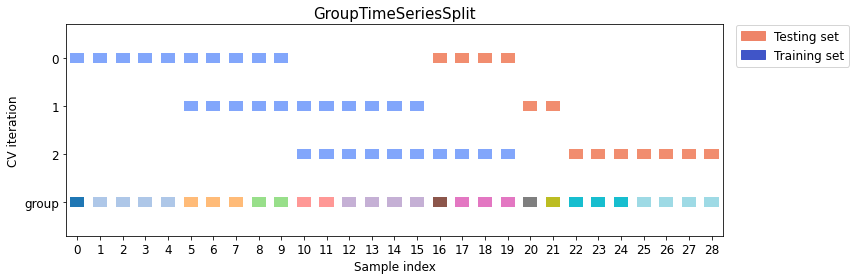

In [121]:
cv_args = {
    'test_size': 2,
    'train_size': 4,
    'n_splits': 3, 
    'shift_size': 2,
    'gap': 2,
    'window': 'rolling'
}
cv = GroupTimeSeriesSplit(**cv_args)

fig, axes = plt.subplots(figsize=(12, 4))
cmap_data = plt.cm.tab20
cmap_cv = plt.cm.coolwarm
plot_cv_indices(cv, X, y, groups, axes, cv_args['n_splits'],
                cmap_data, cmap_cv)